In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from tqdm import tqdm


Epoch 1/10, Loss: 147.1715, Val Accuracy: 0.9756
Epoch 2/10, Loss: 4.2109, Val Accuracy: 0.9756
Epoch 3/10, Loss: 1.8235, Val Accuracy: 0.9756
Epoch 4/10, Loss: 1.0343, Val Accuracy: 0.9756
Epoch 5/10, Loss: 0.6643, Val Accuracy: 0.9756
Epoch 6/10, Loss: 0.4582, Val Accuracy: 0.9756
Epoch 7/10, Loss: 0.3310, Val Accuracy: 0.9756
Epoch 8/10, Loss: 0.2468, Val Accuracy: 0.9756
Epoch 9/10, Loss: 0.1883, Val Accuracy: 0.9756
Epoch 10/10, Loss: 0.1461, Val Accuracy: 0.9756


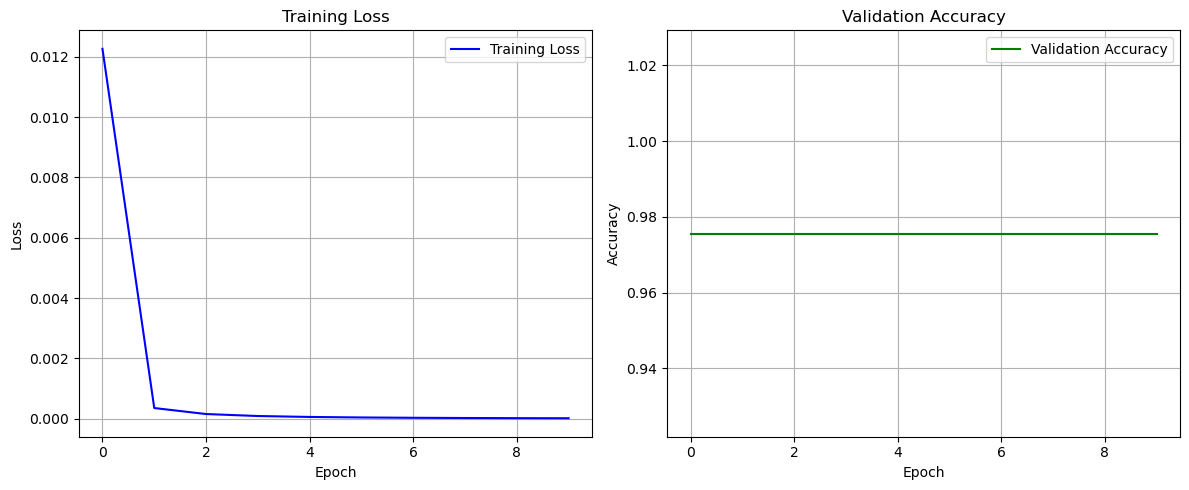

In [2]:
# Custom Dataset Class
class JetDataset(Dataset):
    def __init__(self, node_feats, adj_matrices, labels):
        self.node_feats = node_feats
        self.adj_matrices = adj_matrices
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.node_feats[idx], self.adj_matrices[idx], self.labels[idx]

# Define GAT Model
class GAT(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(GAT, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, node_feats, adj_matrix):
        h = F.elu(self.fc1(node_feats))
        h = self.fc2(h)  # Final layer to output logits for each class
        return h.mean(dim=1)  # Aggregate node features to predict the class for the graph

# Prepare Data
def prepare_data(csv_path):
    df = pd.read_csv(csv_path)
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['signal_or_background'])
    
    node_feats = []
    adj_matrices = []
    labels = []
    max_jets = df.groupby('event_no').size().max()
    
    for event in df['event_no'].unique():
        event_data = df[df['event_no'] == event]
        num_jets = event_data.shape[0]
        features = event_data[['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass']].values
        
        if num_jets < max_jets:
            padding = np.zeros((max_jets - num_jets, 4))
            features = np.vstack((features, padding))
        
        node_feats.append(features)
        
        adj_matrix = np.ones((max_jets, max_jets)) - np.eye(max_jets)
        adj_matrices.append(adj_matrix)
        
        labels.append(event_data['label'].values[0])
    
    node_feats = torch.FloatTensor(np.array(node_feats))
    adj_matrices = torch.FloatTensor(np.array(adj_matrices))
    labels = torch.LongTensor(np.array(labels))
    
    return node_feats, adj_matrices, labels

# Split data based on user-specified split
def split_data(node_feats, adj_matrices, labels):
    bkg_indices = (labels == 0).nonzero(as_tuple=True)[0]
    sig_indices = (labels == 1).nonzero(as_tuple=True)[0]
    
    train_bkg = bkg_indices[:12000]
    val_bkg = bkg_indices[12000:16000]
    test_bkg = bkg_indices[16000:18000]
    val_sig = sig_indices[:100]
    test_sig = sig_indices[100:]
    
    train_idx = train_bkg
    val_idx = torch.cat((val_bkg, val_sig))
    test_idx = torch.cat((test_bkg, test_sig))
    
    train_data = [(node_feats[i], adj_matrices[i], labels[i]) for i in train_idx]
    val_data = [(node_feats[i], adj_matrices[i], labels[i]) for i in val_idx]
    test_data = [(node_feats[i], adj_matrices[i], labels[i]) for i in test_idx]
    
    return train_data, val_data, test_data

# Train Model
import matplotlib.pyplot as plt

# Train Model with Plotting
def train_model(model, train_data, val_data, num_epochs=10, batch_size=32, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for i in range(0, len(train_data), batch_size):
            batch = train_data[i:i+batch_size]
            batch_feats, batch_adj, batch_labels = zip(*batch)
            batch_feats = torch.stack(batch_feats).to(model.device)
            batch_adj = torch.stack(batch_adj).to(model.device)
            batch_labels = torch.tensor(batch_labels, dtype=torch.long).to(model.device)

            optimizer.zero_grad()
            output = model(batch_feats, batch_adj)
            loss = F.cross_entropy(output, batch_labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_data))

        model.eval()
        with torch.no_grad():
            correct, total = 0, 0
            for batch in val_data:
                feats, adj, label = batch
                feats, adj, label = feats.to(model.device), adj.to(model.device), label.to(model.device)
                output = model(feats.unsqueeze(0), adj.unsqueeze(0))
                pred = output.argmax(dim=1)
                correct += (pred == label).sum().item()
                total += 1

            val_accuracy = correct / total
            val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_accuracies

# Plot Training Loss and Validation Accuracy
def plot_metrics(train_losses, val_accuracies):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='green')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main Execution
node_feats, adj_matrices, labels = prepare_data('/home/sandeep/Desktop/pp24tops20KE.csv')
train_data, val_data, test_data = split_data(node_feats, adj_matrices, labels)

model = GAT(in_features=4, hidden_features=8, out_features=2)
model.to(model.device)
train_losses, val_accuracies = train_model(model, train_data, val_data)

# Plot the metrics
plot_metrics(train_losses, val_accuracies)
